# Skin Cancer Classifier

This project started as a nanodegree mini-project, but it became my contribution to the researches in the usage of deep learning in dermatology.

Its goal is to correctly classify a potential skin cancer given only a macroscopic image an the epidermic lesion, so in the future, it can assist dermatologists in day-to-day diagnosys.

To achieve that, I used the [HAM10000 dataset](https://arxiv.org/abs/1803.10417).

You can read more about this research in this article: [Medium Article](https://medium.com).

*Please notice I'm not a dermalogist, nor did I contact one during this research, so there might be some medical misunderstandings.*

In [6]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 9]

In [7]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = to_categorical(np.array(data['target']), 7)
    return files, targets

## Data Augmentation (did not improve the results)

Here I used the ImageDataGenerator from keras to perform data augmentation and balance the quantity of samples among the different classes. However, that did not improve the results, it only made it a little more complex and harder to train. better.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.datasets import load_files

datagen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

def load_img_paths(path):
    data = load_files(path)['filenames']
    return data

def preprocess_augmentation(img_path):
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    return x

def generate_n_imgs_for_img(n, paths):
    for img_path in paths:
        i = 0
        for batch in datagen.flow(preprocess_augmentation(img_path), batch_size=1,
                                  save_to_dir='/'.join(img_path.split('/')[:-1]), save_prefix='aug', save_format='jpg'):
            i += 1
            if i > n - 1:
                break

#generate_n_imgs_for_img(14, ['data/train/akiec/' + x for x in os.listdir('data/train/akiec')])
#generate_n_imgs_for_img(9, ['data/train/bcc/' + x for x in os.listdir('data/train/bcc')])
#generate_n_imgs_for_img(5, ['data/train/bkl/' + x for x in os.listdir('data/train/bkl')])
#generate_n_imgs_for_img(19, ['data/train/df/' + x for x in os.listdir('data/train/df')])
#generate_n_imgs_for_img(4, ['data/train/mel/' + x for x in os.listdir('data/train/mel')])
generate_n_imgs_for_img(4, ['data/train/mel/ISIC_0024640.jpg'])
#generate_n_imgs_for_img(1, ['data/train/nv/' + x for x in os.listdir('data/train/nv')])
#generate_n_imgs_for_img(19, ['data/train/vasc/' + x for x in os.listdir('data/train/vasc')])

## Loading dataset (1st time)

This cell is used to generate all data folders and distribute all images among the folders.

In [135]:
target_names = [item.split('\\')[1] for item in sorted(glob('data\\*\\'))]

files, targets = load_dataset('data\\')

X_train, X_test, y_train, y_test = train_test_split(files, targets, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('There are %d total categories.' % len(target_names))
print('These are the categories: %s' % ' '.join(target_names))
print('There are %d total images.\n' % len(files))

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_val))
print('There are %d test images.\n'% len(y_test))


os.mkdir('data\\train')
os.mkdir('data\\test')
os.mkdir('data\\valid')

for name in target_names:
    os.mkdir('data\\train\\{}'.format(name))
    os.mkdir('data\\test\\{}'.format(name))
    os.mkdir('data\\valid\\{}'.format(name))

for i in range(len(X_train)):
    os.rename(X_train[i], 'data\\train\\{}\\{}'.format(target_names[np.argmax(y_train[i])], X_train[i].split('\\')[2]))
    
for i in range(len(X_test)):
    os.rename(X_test[i], 'data\\test\\{}\\{}'.format(target_names[np.argmax(y_test[i])], X_test[i].split('\\')[2]))
    
for i in range(len(X_val)):
    os.rename(X_val[i], 'data\\valid\\{}\\{}'.format(target_names[np.argmax(y_val[i])], X_val[i].split('\\')[2]))
    


There are 7 total categories.
These are the categories: akiec bcc bkl df mel nv vasc
There are 10015 total images.

There are 6409 training images.
There are 1603 validation images.
There are 2003 test images.



## Loading dataset (2nd time and beyond)

Load data after the images are distributed among data folders.

In [26]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = to_categorical(np.array(data['target']), 7)
    return files, targets

X_train, y_train = load_dataset('data\\train')
X_test, y_test = load_dataset('data\\test')
X_val, y_val = load_dataset('data\\valid')

target_names = [item.split('\\')[2] for item in sorted(glob('data\\train\\*\\'))]

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_val))
print('There are %d test images.\n'% len(y_test))

print('There are %d total categories.' % len(target_names))
print('These are the categories: %s' % ' '.join(target_names))

There are 6409 training images.
There are 1603 validation images.
There are 2003 test images.

There are 7 total categories.
These are the categories: akiec bcc bkl df mel nv vasc


## Image preprocessing

The images of this dataset are 600x450, so they are cut in the center into 299x299 and then every pixel is normalized. Resizing the picture did far worse than just cutting it, probably because the shape of the skin lesion is very revelant for the diagnosys, and that information is partially lost in resizing.

The color is also important, so grayscale is not an option.

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tqdm import tqdm
from skimage import io

def path_to_tensor(img_path):
    img = io.imread(img_path)
    x = img[75:374, 150:449]
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    
    return x


## Feature Extraction with Xception

Xception is the CNN I chose to extract features from every image. I tried lots of different networks, but Xception gave me the best result.

In [10]:
from tensorflow.keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False, pooling='avg')

def extract_features(path):
    tensor = path_to_tensor(path)
    return xception_model.predict(tensor).flatten()


In [141]:
train_features = np.array(list(map(extract_features, X_train)))
valid_features = np.array(list(map(extract_features, X_val)))
test_features = np.array(list(map(extract_features, X_test)))

### Saving features for future usage (takes a while)

In [142]:
np.save('features/train_multi_xception_center.npy', train_features)
np.save('features/valid_multi_xception_center.npy', valid_features)
np.save('features/test_multi_xception_center.npy', test_features)

### Loading features (run from here after saving the first time)

In [27]:
train_features = np.load('features/train_multi_xception_center.npy')
valid_features = np.load('features/valid_multi_xception_center.npy')
test_features = np.load('features/test_multi_xception_center.npy')

In [12]:
print('There are %d features per image\n' % len(valid_features[0]))
print('There are %d training images.' % len(train_features))
print('There are %d validation images.' % len(valid_features))
print('There are %d test images.'% len(test_features)) 


There are 2048 features per image

There are 6409 training images.
There are 1603 validation images.
There are 2003 test images.


# Building a classifier

Here I use a few FC layers to build a classifier. BatchNormalization worked out better than Dropout in preventing overfitting.

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Dense(2048, input_shape=[len(train_features[0])]))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Dense(len(target_names)))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_18 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_21 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 3591      
__________

Surprisingly, SGD got me better results than Adam, RMSProp, etc.

In [106]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


## Training the classifier

Besides adding BatchNormalization layers, class weighting and mini batching also helped on the task of avoiding overfitting.

The quantity of images for each class is not balanced. Nearly 70% of the images belong to the "nv" class, so I used the quantity of "nv" images (6705) divided by the quantity of each class image and multiplied by a bias coefficient to point the training into the direction I want.

I also performed manual early stopping when I noticed overfitting.

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

class_weight = {
    0: 6705 / 327, #akiec
    1: 6705 / 514, #bcc
    2: 6705 / 1099, #bkl
    3: 6705 / 115 * 2, #df
    4: 6705 / 1113, #mel
    5: 1 / 1.5, #nv
    6: 6705 / 142 #vasc
}

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')

history = model.fit(train_features, y_train, 
          validation_data=(valid_features, y_val),
          epochs=300, batch_size=512, callbacks=[checkpointer, early_stopping], verbose=1,
          shuffle=True, class_weight=class_weight)



Train on 6409 samples, validate on 1603 samples
Epoch 1/300
6144/6409 [===========================>..] - ETA: 18s - loss: 2.0779 - acc: 0.15 - ETA: 5s - loss: 2.0926 - acc: 0.1654 - ETA: 3s - loss: 1.9831 - acc: 0.178 - ETA: 2s - loss: 1.8830 - acc: 0.191 - ETA: 1s - loss: 1.7761 - acc: 0.213 - ETA: 0s - loss: 1.7452 - acc: 0.226 - ETA: 0s - loss: 1.6731 - acc: 0.2414
Epoch 00001: val_loss improved from inf to 1.59843, saving model to saved_models/weights.best.xception.hdf5
6409/6409 [==============================] - 3s 544us/step - loss: 1.6752 - acc: 0.2453 - val_loss: 1.5984 - val_acc: 0.5646
Epoch 2/300
6144/6409 [===========================>..] - ETA: 0s - loss: 1.1854 - acc: 0.361 - ETA: 0s - loss: 1.1299 - acc: 0.349 - ETA: 0s - loss: 1.1699 - acc: 0.348 - ETA: 0s - loss: 1.1649 - acc: 0.360 - ETA: 0s - loss: 1.1375 - acc: 0.363 - ETA: 0s - loss: 1.1269 - acc: 0.370 - ETA: 0s - loss: 1.1229 - acc: 0.3748
Epoch 00002: val_loss did not improve from 1.59843
6409/6409 [============

6409/6409 [==============================] - 1s 111us/step - loss: 0.2737 - acc: 0.7597 - val_loss: 0.9359 - val_acc: 0.6887
Epoch 33/300
6144/6409 [===========================>..] - ETA: 0s - loss: 0.3092 - acc: 0.750 - ETA: 0s - loss: 0.2604 - acc: 0.745 - ETA: 0s - loss: 0.2579 - acc: 0.756 - ETA: 0s - loss: 0.2600 - acc: 0.771 - ETA: 0s - loss: 0.2638 - acc: 0.767 - ETA: 0s - loss: 0.2748 - acc: 0.764 - ETA: 0s - loss: 0.2767 - acc: 0.7653
Epoch 00033: val_loss did not improve from 0.93593
6409/6409 [==============================] - 1s 97us/step - loss: 0.2732 - acc: 0.7661 - val_loss: 0.9681 - val_acc: 0.6750
Epoch 34/300
5632/6409 [=========================>....] - ETA: 0s - loss: 0.2056 - acc: 0.794 - ETA: 0s - loss: 0.2589 - acc: 0.781 - ETA: 0s - loss: 0.2698 - acc: 0.772 - ETA: 0s - loss: 0.2680 - acc: 0.774 - ETA: 0s - loss: 0.2646 - acc: 0.773 - ETA: 0s - loss: 0.2603 - acc: 0.7694
Epoch 00034: val_loss improved from 0.93593 to 0.92487, saving model to saved_models/weights

Epoch 66/300
5632/6409 [=========================>....] - ETA: 0s - loss: 0.1471 - acc: 0.871 - ETA: 0s - loss: 0.1399 - acc: 0.862 - ETA: 0s - loss: 0.1319 - acc: 0.864 - ETA: 0s - loss: 0.1347 - acc: 0.860 - ETA: 0s - loss: 0.1361 - acc: 0.861 - ETA: 0s - loss: 0.1374 - acc: 0.8615
Epoch 00066: val_loss improved from 0.76868 to 0.75648, saving model to saved_models/weights.best.xception.hdf5
6409/6409 [==============================] - 1s 112us/step - loss: 0.1341 - acc: 0.8636 - val_loss: 0.7565 - val_acc: 0.7380
Epoch 67/300
5632/6409 [=========================>....] - ETA: 0s - loss: 0.1078 - acc: 0.845 - ETA: 0s - loss: 0.1153 - acc: 0.864 - ETA: 0s - loss: 0.1212 - acc: 0.868 - ETA: 0s - loss: 0.1248 - acc: 0.860 - ETA: 0s - loss: 0.1304 - acc: 0.857 - ETA: 0s - loss: 0.1303 - acc: 0.8596
Epoch 00067: val_loss did not improve from 0.75648
6409/6409 [==============================] - 1s 98us/step - loss: 0.1319 - acc: 0.8607 - val_loss: 0.7622 - val_acc: 0.7424
Epoch 68/300
5632/

Epoch 00099: val_loss improved from 0.68540 to 0.66708, saving model to saved_models/weights.best.xception.hdf5
6409/6409 [==============================] - 1s 112us/step - loss: 0.0831 - acc: 0.9076 - val_loss: 0.6671 - val_acc: 0.7673
Epoch 100/300
5632/6409 [=========================>....] - ETA: 0s - loss: 0.0783 - acc: 0.935 - ETA: 0s - loss: 0.0778 - acc: 0.916 - ETA: 0s - loss: 0.0826 - acc: 0.909 - ETA: 0s - loss: 0.0835 - acc: 0.906 - ETA: 0s - loss: 0.0836 - acc: 0.907 - ETA: 0s - loss: 0.0823 - acc: 0.9047
Epoch 00100: val_loss did not improve from 0.66708
6409/6409 [==============================] - 1s 99us/step - loss: 0.0819 - acc: 0.9051 - val_loss: 0.6821 - val_acc: 0.7704
Epoch 101/300
5632/6409 [=========================>....] - ETA: 0s - loss: 0.0792 - acc: 0.896 - ETA: 0s - loss: 0.0767 - acc: 0.902 - ETA: 0s - loss: 0.0772 - acc: 0.906 - ETA: 0s - loss: 0.0802 - acc: 0.905 - ETA: 0s - loss: 0.0809 - acc: 0.909 - ETA: 0s - loss: 0.0804 - acc: 0.9118
Epoch 00101: val

5632/6409 [=========================>....] - ETA: 0s - loss: 0.0471 - acc: 0.962 - ETA: 0s - loss: 0.0525 - acc: 0.946 - ETA: 0s - loss: 0.0535 - acc: 0.945 - ETA: 0s - loss: 0.0557 - acc: 0.938 - ETA: 0s - loss: 0.0549 - acc: 0.939 - ETA: 0s - loss: 0.0559 - acc: 0.9377
Epoch 00133: val_loss did not improve from 0.62867
6409/6409 [==============================] - 1s 101us/step - loss: 0.0560 - acc: 0.9363 - val_loss: 0.6637 - val_acc: 0.7735
Epoch 134/300
6144/6409 [===========================>..] - ETA: 0s - loss: 0.0566 - acc: 0.945 - ETA: 0s - loss: 0.0598 - acc: 0.934 - ETA: 0s - loss: 0.0577 - acc: 0.936 - ETA: 0s - loss: 0.0568 - acc: 0.936 - ETA: 0s - loss: 0.0580 - acc: 0.937 - ETA: 0s - loss: 0.0560 - acc: 0.935 - ETA: 0s - loss: 0.0557 - acc: 0.9370
Epoch 00134: val_loss did not improve from 0.62867
6409/6409 [==============================] - 1s 102us/step - loss: 0.0555 - acc: 0.9371 - val_loss: 0.6574 - val_acc: 0.7742
Epoch 135/300
5632/6409 [=========================>.

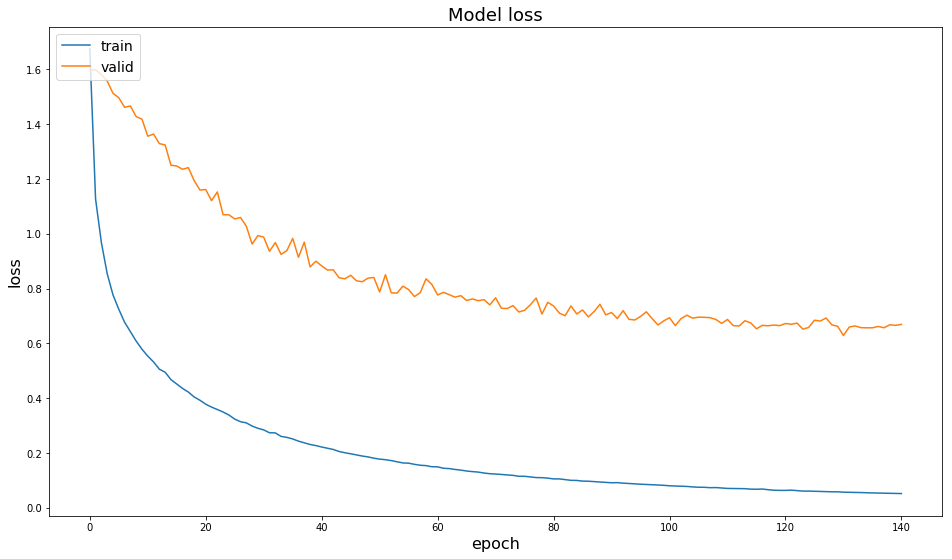

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'valid'], loc='upper left', fontsize=14)
plt.savefig('my_results/model-loss.png')
plt.show()

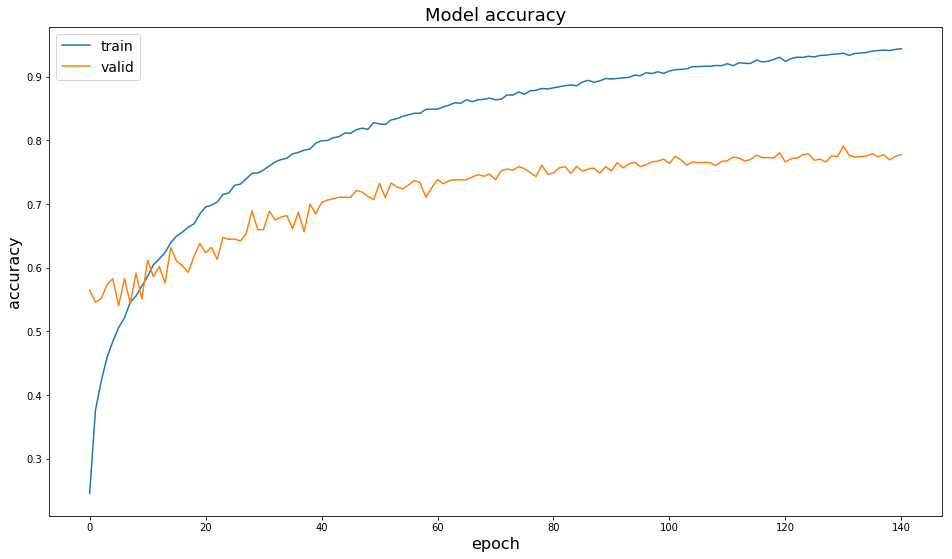

In [131]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'valid'], loc='upper left', fontsize=14)
plt.savefig('my_results/modal-accuracy.png')
plt.show()

## Evaluating the model

The regular accuracy is not a very good metric to evaluate this kind of problem, because again, the data is not balanced, so just guessing "nv" every time would already achieve ~67% accuracy.

In [110]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_features]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 76.2856%


In [111]:
print('The labels are ordered like this: %s' % ', '.join(target_names))

The labels are ordered like this: akiec, bcc, bkl, df, mel, nv, vasc


In [112]:
y_true = [np.argmax(x) for x in y_test]

### 7-label Confusion Matrix

The confusion matrix shows us a lot more of information about the classifier than the simple accuracy.

This confusion matrix shows us that even tought perfect balance was not achieved, it is still much better than it was before (nv got 97% accuracy while others were all below 30%).


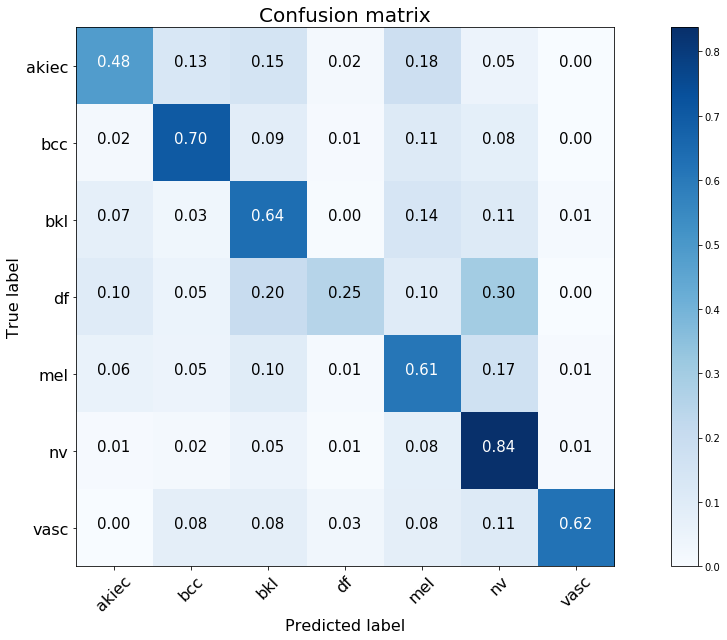

In [134]:
import itertools
from sklearn.metrics import confusion_matrix

# import some data to play with
class_names = target_names

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0] - 1, -1, -1), range(cm.shape[1] - 1, -1, -1)):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=15,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, predictions)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')
plt.savefig('my_results/confunsion-7.png')
plt.show()


## ROC Curves

The ROC Curve is one of the best ways to evaluate categorical classifiers, as the AUC (Area Under Curve) value roughly indicates how well the predictions are going by correlating TPR and FPR.

Here we can see that our model is doing pretty good for most of the classes, and has a nice micro and macro-average ROC AUC score.

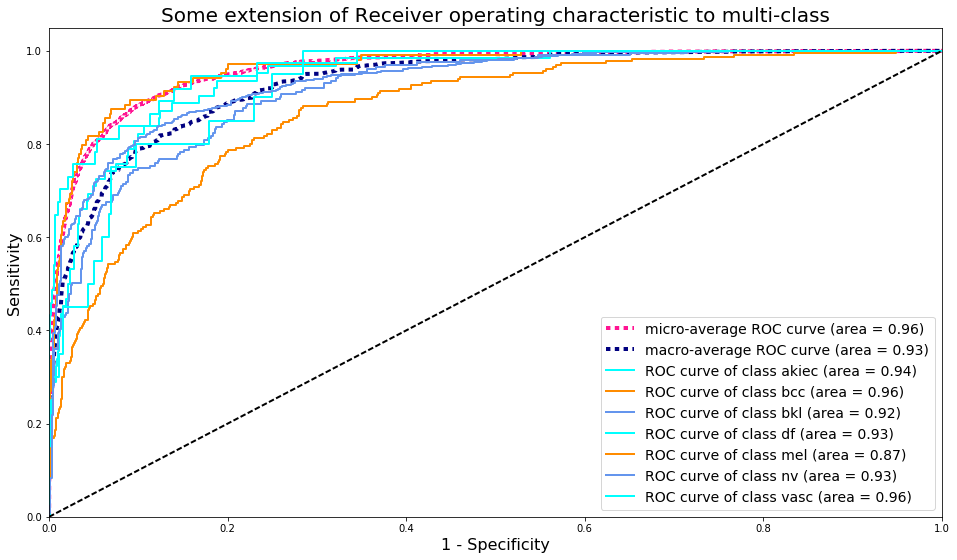

In [137]:
from sklearn.metrics import roc_curve, auc

n_classes = 7
y_score = model.predict(test_features)

lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=16)
plt.ylabel('Sensitivity', fontsize=16)
plt.title('Some extension of Receiver operating characteristic to multi-class', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('my_results/roc-7.png')
plt.show()

## Turning a multi-label classifier into a binary one

The [HAM1000 paper](https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf) suggests that three classes are either cancer or precancer diagnosys, while the others are not. That's why I considered those three labels (akiec, bcc and mel) to be "potential cancer" and the rest to be "not cancer".

I also want to reduce the number of false negatives as much as possible (in other words, increasing the sensivity), because I consider "sending sick people home" worse than "sending healthy people to do more exams", so I introduce an adjustable threshold.

Here's how it works:

If the mean of the percentage from the three "potential cancer" classes plus a given bias is higher or equal to the threshold, it is labeled as "potential cancer". Otherwise, it is labeled as "not cancer".

To evaluate the model, I used another confusion matrix and a table with a few of the most common metrics.

*The y_true array used to compare with the model's prediction consider only the argxmax value of each prediction to be one of the potential cancer classes or not.*

,Accuracy,ROC AUC,Sensitivity,Specificity
0,0.754868,0.823444,0.936869,0.710019


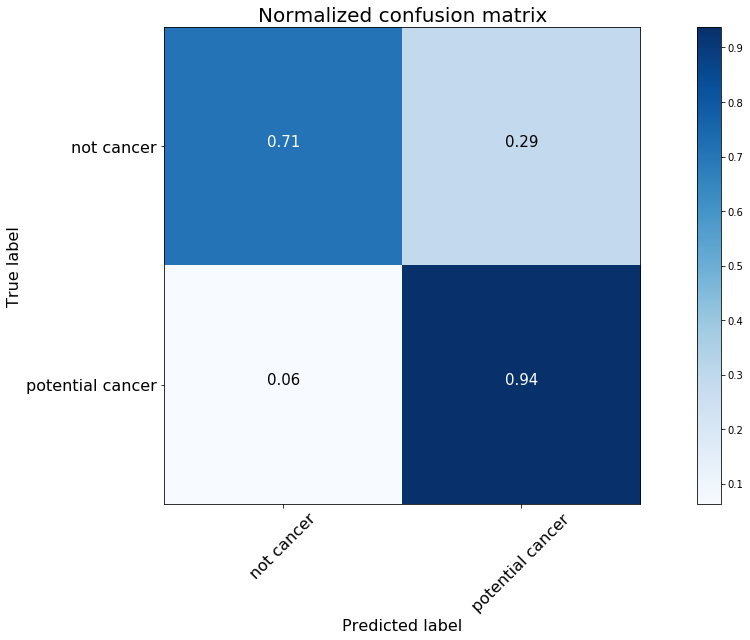

In [139]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

def mel_vs_rest(classification, threshold=1/7, bias=0):
    return 1 if np.mean([classification[0], classification[1], classification[4]]) + bias >= threshold else 0

class_names = ['not cancer', 'potential cancer']

t_predictions = [mel_vs_rest(model.predict(np.expand_dims(feature, axis=0))[0], threshold=1/7, bias=1/10) for feature in test_features]
t_y_true = [1 if x in [0, 1, 4] else 0 for x in y_true]

accuracy = len([i for i in range(len(t_predictions)) if t_predictions[i] == t_y_true[i]]) / len(t_predictions)

# Compute confusion matrix
cnf_matrix = confusion_matrix(t_y_true, t_predictions)
true_negative, false_positive, false_negative, true_positive = cnf_matrix.ravel()

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                     title='Normalized confusion matrix')
plt.savefig('my_results/confusion.png')

sensitivity = true_positive / (true_positive + false_negative) # this is also the recall
specificity = true_negative / (true_negative + false_positive)

'''print("Accuracy: %.3f" % accuracy)
print("Sensitivity (or recall): %.3f" % sensitivity)
print("Specificity: %.3f" % specificity)
print("Positive Prediction Value: %.3f" % ppv)
print("Negative Pred)
print("ROC Score: %.3f" % roc_auc_score(t_y_true, t_predictions))'''

binary_d = {
    'Accuracy': [accuracy],
    'Sensitivity': [sensitivity],
    'Specificity': [specificity],
    'ROC AUC': [roc_auc_score(t_y_true, t_predictions)]
}

binary_df = pd.DataFrame(binary_d)
binary_df.to_csv('my_results/metrics.csv', index=False)
binary_df.head()

## Conclusions

This was my first relevant solo project that involved building and training predictive models, it was really fun and educative.

There is probably a lot of room for improvement but to keep going further I would need some resources I don't have.

Besides that, I do think deep learning (and machine learning in general) can and will be used in the task of helping doctors dianosing all kinds of diseases. This is just a scratch in the surface of what predictive models can do.

**Please feel free to fork this repo and continue my work if you wish to!**